In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

from random import randint
from db.session import get_last_data_by_symbol
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

In [22]:
recordsAll = get_last_data_by_symbol(symbol="xem")

# Convert result to Pandas DataFrame
df = pd.DataFrame(recordsAll.fetchall(), columns=list(recordsAll.keys()))

# Set the timestamp column as the index
df.set_index('created_at', inplace=True)

In [23]:
df["price_change"] = df["lastPrice"].pct_change()
df["volume_change"] = df["volume24h"].pct_change()
df["bid_ask_ratio"] = (df["bid1Size"] / (df["ask1Size"] + 1e-9))

df["mean_price_2"] = df["price_change"].rolling(window=2).mean()
df["mean_price_4"] = df["price_change"].rolling(window=4).mean()
#df["mean_price_8"] = df["price_change"].rolling(window=8).mean()

df["mean_volume_2"] = df["volume_change"].rolling(window=2).mean()
df["mean_volume_4"] = df["volume_change"].rolling(window=4).mean()
#df["mean_volume_8"] = df["volume_change"].rolling(window=8).mean()
df["mean_volume_8_16"] = df["volume_change"].shift(8).rolling(window=8).mean()

df["mean_bid_ask_ratio_4"] = df["bid_ask_ratio"].rolling(window=4).mean()
df["mean_bid_ask_ratio_8_16"] = df["bid_ask_ratio"].shift(8).rolling(window=8).mean()

# Target
lp_shift_3 = df["lastPrice"].shift(-3).rolling(window=3).mean()
lp_shift_3_6 = df["lastPrice"].shift(-6).rolling(window=3).mean()

df["future_return_pcnt_3"] = (lp_shift_3 - df["lastPrice"]) / df["lastPrice"] * 100
df["future_return_pcnt_6"] = (lp_shift_3_6 - df["lastPrice"]) / df["lastPrice"] * 100


df["target_lp_sh_3"] = (df["future_return_pcnt_3"] >= 2).astype(int)
df["target_lp_sh_6"] = (df["future_return_pcnt_6"] >= 5).astype(int)

# Final target combining both conditions
# 1 if either condition is met, else 0
df["final_target"] = (df["future_return_pcnt_6"] >= 7).astype(int)

skewness = df["lastPrice"].skew()
kurtosis = df["lastPrice"].kurtosis()
min_price = df["lastPrice"].min()
max_price = df["lastPrice"].max()
price_difference = max_price - min_price
percentage_difference_from_min = (price_difference / min_price) * 100

print(f"Skewness of lastPrice: {skewness}")
print(f"Kurtosis of lastPrice: {kurtosis}")
print(f"Minimum of lastPrice: {min_price}")
print(f"Maximum of lastPrice: {max_price}")
print(f"Percentage Difference from Minimum: {percentage_difference_from_min}%")

# Drop rows with NaN values
df.dropna(inplace=True)

Skewness of lastPrice: 0.6665847968488028
Kurtosis of lastPrice: -0.10585959400764144
Minimum of lastPrice: 0.00285
Maximum of lastPrice: 0.00755
Percentage Difference from Minimum: 164.91228070175438%


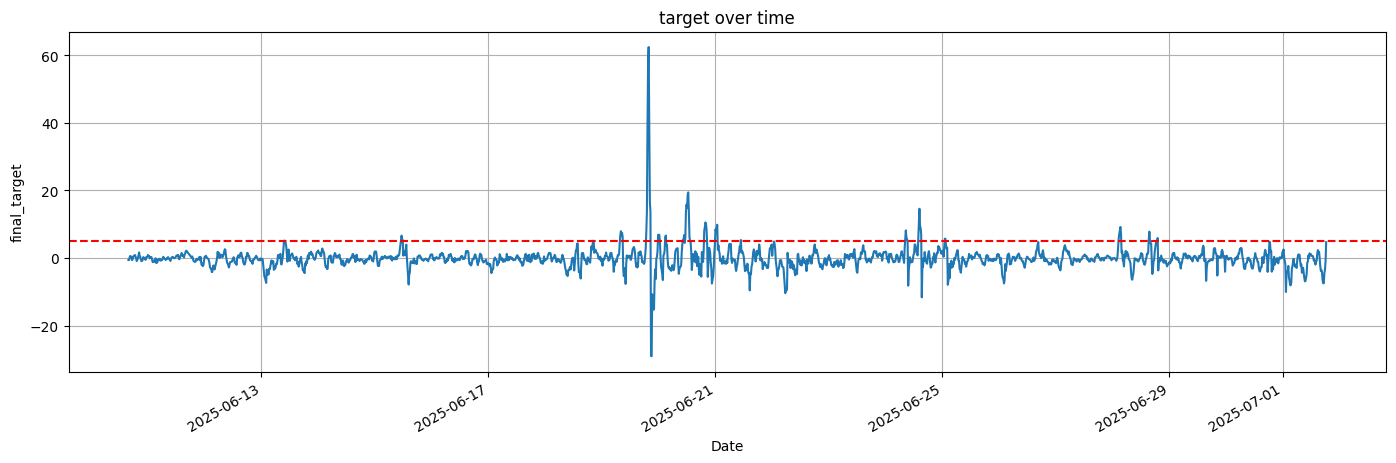

In [24]:
df["future_return_pcnt_6"].plot(figsize=(17, 5), title="target over time")

plt.xlabel("Date")
plt.ylabel("final_target")
plt.grid(True)
# a line at y=5
plt.axhline(y=5, color='r', linestyle='--', label='Threshold 5%')
plt.show()

In [26]:

# Define the columns for scalling
columns_to_scale = ["price_change", "volume_change", "bid_ask_ratio", 
                    "mean_price_2", "mean_price_4","mean_volume_2", "mean_volume_4", 
                    "mean_volume_8_16", "mean_bid_ask_ratio_4", "mean_bid_ask_ratio_8_16"]

# 1. Select column
df_to_scale = df[columns_to_scale]

# 2. Create and learn the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df_to_scale)

# 3. Return to DataFrame
scaled_df_part = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)
final_scaled_df = pd.concat([scaled_df_part, df["final_target"]], axis=1)


In [28]:
# Prepare tensor data
X = final_scaled_df[columns_to_scale].values
y = final_scaled_df["final_target"].values
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: torch.Size([2014, 10]), y shape: torch.Size([2014, 1])


**Model**